# Distribution B - Maximum Likelihood - In X

In [4]:
import DistExampB as db

import sympy as sp
import cvxpy as cp

from matplotlib import pyplot as plot
from numpy import sinc
from sympy import Symbol, integrate, lambdify

from LocUtil import Grid1, LogGrid1, MinMax, MinIndex, SetSeed, UnZip
from Map import LogRatio
# from Sinc import InterpZ

## Basic Setup

In [5]:
nSamp = 400

givenSeed = None
seedDig = 3

nPlot = 101
figSize = (9, 6.5)

dist = db.ExampB()

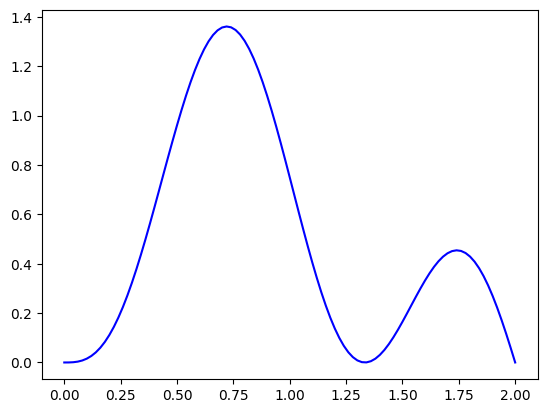

In [6]:
xGrid = Grid1(0,2, nPlot)
pdfX = tuple(dist.Pdf(x) for x in xGrid)

plot.plot(xGrid,pdfX, c='blue')

In [7]:
seed = SetSeed(givenSeed, seedDig)
if givenSeed is None:
	print(f'seed = {seed}')

sampX = sorted(tuple(dist.Sample() for _ in range(nSamp)))
quant = tuple((k + 0.5) / nSamp for k in range(nSamp))

seed = 425


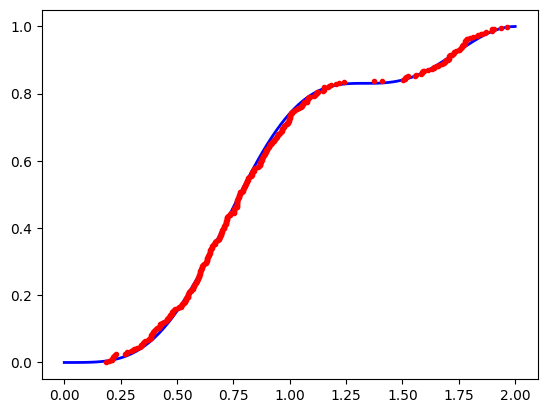

In [8]:
plot.plot(sampX,quant, '.', c='red')

xGrid = Grid1(0,2,nPlot)
cdfX = tuple(dist.Cdf(x) for x in xGrid)
plot.plot(xGrid, cdfX, c="blue", lw=2, zorder=-1)

## Change of Variable

In [9]:
xSym = Symbol('x')
zSym = Symbol('z')

map_ = LogRatio(xSym, zSym, (0, 2))

In [10]:
map_.forSym

log(x/(2 - x))

In [11]:
sampZ = tuple(map_.Forward(x) for x in sampX)

In [12]:
zMin,zMax = MinMax(sampZ)
zMin,zMax

(-2.2932712921875584, 3.9461473533119786)

In [13]:
phiPrimeSym = (1 / map_.forSym.diff(xSym)).factor()
phiPrimeX = lambdify(xSym, phiPrimeSym)
phiPrimeSym

-x*(x - 2)/2

## Maximize Log-Likelihood for Sinc Approx of PDF(x)

In [14]:
nSinc = 11
sincZ = Grid1(zMin,zMax, nSinc)
sincX = tuple(map_.Inverse(z) for z in sincZ)
h = (zMax - zMin) / (nSinc - 1)

In [15]:
nSinc, h

(11, 0.6239418645499537)

In [16]:
sincVal = cp.Variable(nSinc)
sincVal

Variable((11,), var1)

## Fit to Samples

In [17]:
phiX = lambdify(xSym, map_.forSym)
logLikeP = lambda x: (
	cp.log(sum(sv * sinc((phiX(x) - sz) / h) for (sz,sv) in zip(sincZ, sincVal))))
obj = cp.Maximize(sum(logLikeP(x) for x in sampX))

In [18]:
constEach = list(0 <= v for v in sincVal)
constArea = h * sum(v * phiPrimeX(x) for (x,v) in zip(sincX, sincVal)) == 1

const = constEach + [constArea]

In [19]:
prob = cp.Problem(obj, const)

F:\Users\Kenne.DESKTOP-BT6VROU\AppData\Local\Programs\Python\Python312\Lib\site-packages\cvxpy\problems\problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


In [25]:
obj

Maximize(Expression(CONCAVE, UNKNOWN, ()))

In [26]:
prob.solve()

                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Aug 17 04:28:27 PM: Your problem has 11 variables, 12 constraints, and 0 parameters.
(CVXPY) Aug 17 04:28:27 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 17 04:28:27 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 17 04:28:27 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Aug 17 04:28:27 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 17 04:28:27 PM: Using cached ASA map, for faster compilatio

-118.0387139397169

In [21]:
sincV = list(sincVal.value)

In [22]:
h * sum(v * phiPrimeX(x) for (x,v) in zip(sincX,sincV))

0.9999999974017472

### Distribution Estimate on X

Text(0, 0.5, 'PDF')

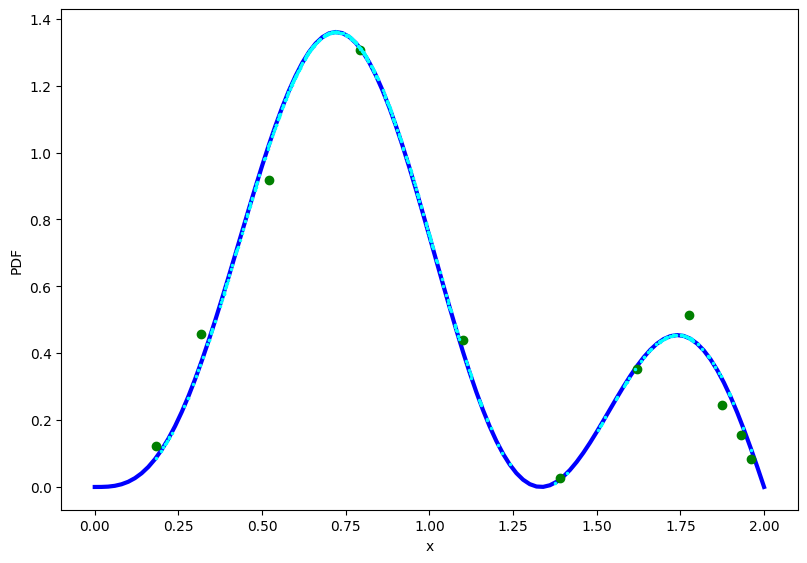

In [23]:
plot.subplots(figsize=(9.5, 6.5))

# show ture PDF in X
xGrid = Grid1(0,2, nPlot)
pdfX = tuple(dist.Pdf(x) for x in xGrid)
plot.plot(xGrid,pdfX, c='blue', linewidth=3)

# show the estiment of the PDF in X
plot.plot(sincX,sincV, 'o', c='green')

xGrid = tuple(2*(k + 0.5) / nPlot for k in range(nPlot))
zGrid = tuple(map_.Forward(x) for x in xGrid)
# interpV = InterpZ(sincZ,sincV, zGrid)
# plot.plot(xGrid,interpV, '--', c='green')

# # show samples
sampPdf = tuple(dist.Pdf(x) for x in sampX)
plot.plot(sampX,sampPdf, '.', c='cyan', markersize=3)

plot.xlabel('x')
plot.ylabel('PDF')